# Experiment number 7 (cifar100):

## tuning model from hard to easy: train model on 50% hard dataset and add data to model every few epochs until the model is trained on all dataset, in this experiment we test different approaches of tuning
## the metrics: EL2N, forget, flip, pred sum, std and km

### get dataset and metrics and print correlation


In [14]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import Tensor

from train import ModelManager, DIR_ROOT_SAVE, DIR_ROOT_LOG
from utils import get_loader, get_cifar100

# globals
NUM_CLASSES = 100
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 60

NOTEBOOK_NAME = 'prune_10_70_p'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar100', 'model', 'other.pt')
PATH_LOG = os.path.join(DIR_ROOT_LOG, NOTEBOOK_NAME, 'test_acc.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar100()
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km55 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist.npy'))
km100 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist_100.npy'))
km200 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist_200.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_true_forget = true_forget.sort()[1].numpy()
idx_sorted_km55 = np.argsort(km55)
idx_sorted_km100 = np.argsort(km100)
idx_sorted_km200 = np.argsort(km200)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'forget': idx_sorted_forgetting, 'true_forget': idx_true_forget,
              'km55': idx_sorted_km55, 'km100': idx_sorted_km100, 'km200': idx_sorted_km200}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'Forget': change_counter.numpy(),
    'true_forget': true_forget.numpy(),
    'km55': km55,
    'km100': km100,
    'km200': km200
})
data.corr()

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


,EL2N,Std,True p sum,Forget,true_forget,km55,km100,km200
EL2N,1.000000,0.763640,-0.931154,0.631182,0.015292,0.299591,0.364110,0.382782
Std,0.763640,1.000000,-0.653038,0.667967,0.121611,0.384026,0.440735,0.461708
True p sum,-0.931154,-0.653038,1.000000,-0.544786,0.114446,-0.250940,-0.299588,-0.316367
Forget,0.631182,0.667967,-0.544786,1.000000,0.394457,0.306184,0.355912,0.370274
true_forget,0.015292,0.121611,0.114446,0.394457,1.000000,0.006370,0.025260,0.031864
km55,0.299591,0.384026,-0.250940,0.306184,0.006370,1.000000,0.805662,0.737580
km100,0.364110,0.440735,-0.299588,0.355912,0.025260,0.805662,1.000000,0.841076
km200,0.382782,0.461708,-0.316367,0.370274,0.031864,0.737580,0.841076,1.000000


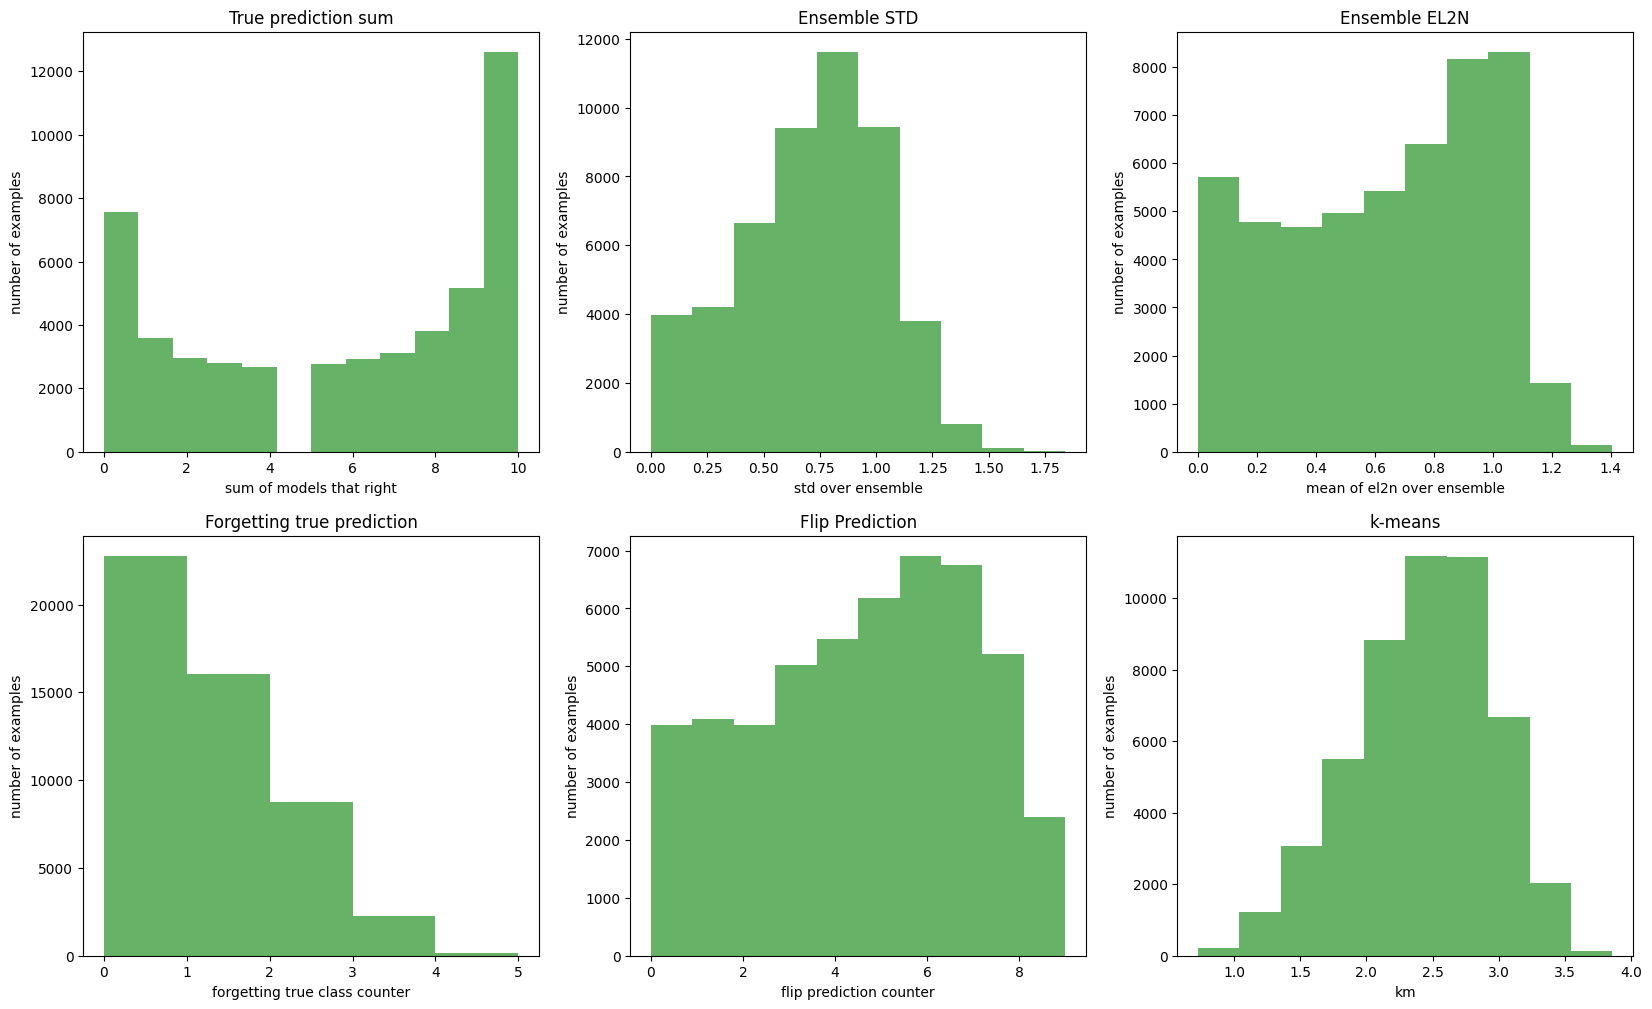

In [13]:
for ax, measure, title, x_label, bins in zip(
        plt.subplots(2, 3, figsize=(20, 12))[1].reshape(-1),
        [ensemble_pred_sum.numpy(), ensemble_std.sum(dim=1).numpy(), el2n_scores.numpy(), true_forget.numpy(),
         change_counter.numpy(), km100],
        ['True prediction sum', 'Ensemble STD', 'Ensemble EL2N', 'Forgetting true prediction', 'Flip Prediction',
         'k-means'],
        ['sum of models that right', 'std over ensemble', 'mean of el2n over ensemble', 'forgetting true class counter',
         'flip prediction counter', 'km'],
        [10, 10, 10, 5, 10, 10]):
    ax.set_ylabel('number of examples')
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.hist(measure, bins=bins, facecolor='g', alpha=0.6)
plt.show()

In [18]:
# change to false in the first time you run this code
# after the first time the model will saved in models_data folder
already_trained = True

no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_=NOTEBOOK_NAME, load=already_trained)
if not already_trained:
    loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, True)
    no_prune.train(loader_train, loader_test, loader_test, EPOCHS)

exp_num = 0
already_trained_0 = True
acc = {'no_prune': no_prune.data['valid']['acc']}

print()
for name, idx in idx_sorted.items():
    model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_exp{exp_num}', dir_=NOTEBOOK_NAME,
                                 load=already_trained_0)

    for epochs, presents in [(10, .5), (5, .6), (5, .7), (5, .8), (5, .9), (40, 1.)]:
        print(f'====     train model with {presents}% according to {name} method    ======')
        if not already_trained_0:
            loader_train = get_loader(dataset_train, idx[-round(presents * NUM_TRAIN):], batch_size=BATCH_SIZE,
                                      shuffle=True)
            model_manager.train(loader_train, loader_test, loader_test, epochs)
        acc[name] = model_manager.data['valid']['acc']
        print()

Adjusting learning rate of group 0 to 1.0000e-03.

Adjusting learning rate of group 0 to 1.0000e-03.
====     train model with 0.5% according to random method    ======

====     train model with 0.6% according to random method    ======

====     train model with 0.7% according to random method    ======

====     train model with 0.8% according to random method    ======

====     train model with 0.9% according to random method    ======

====     train model with 1.0% according to random method    ======

Adjusting learning rate of group 0 to 1.0000e-03.
====     train model with 0.5% according to el2n method    ======

====     train model with 0.6% according to el2n method    ======

====     train model with 0.7% according to el2n method    ======

====     train model with 0.8% according to el2n method    ======

====     train model with 0.9% according to el2n method    ======

====     train model with 1.0% according to el2n method    ======

Adjusting learning rate of group 

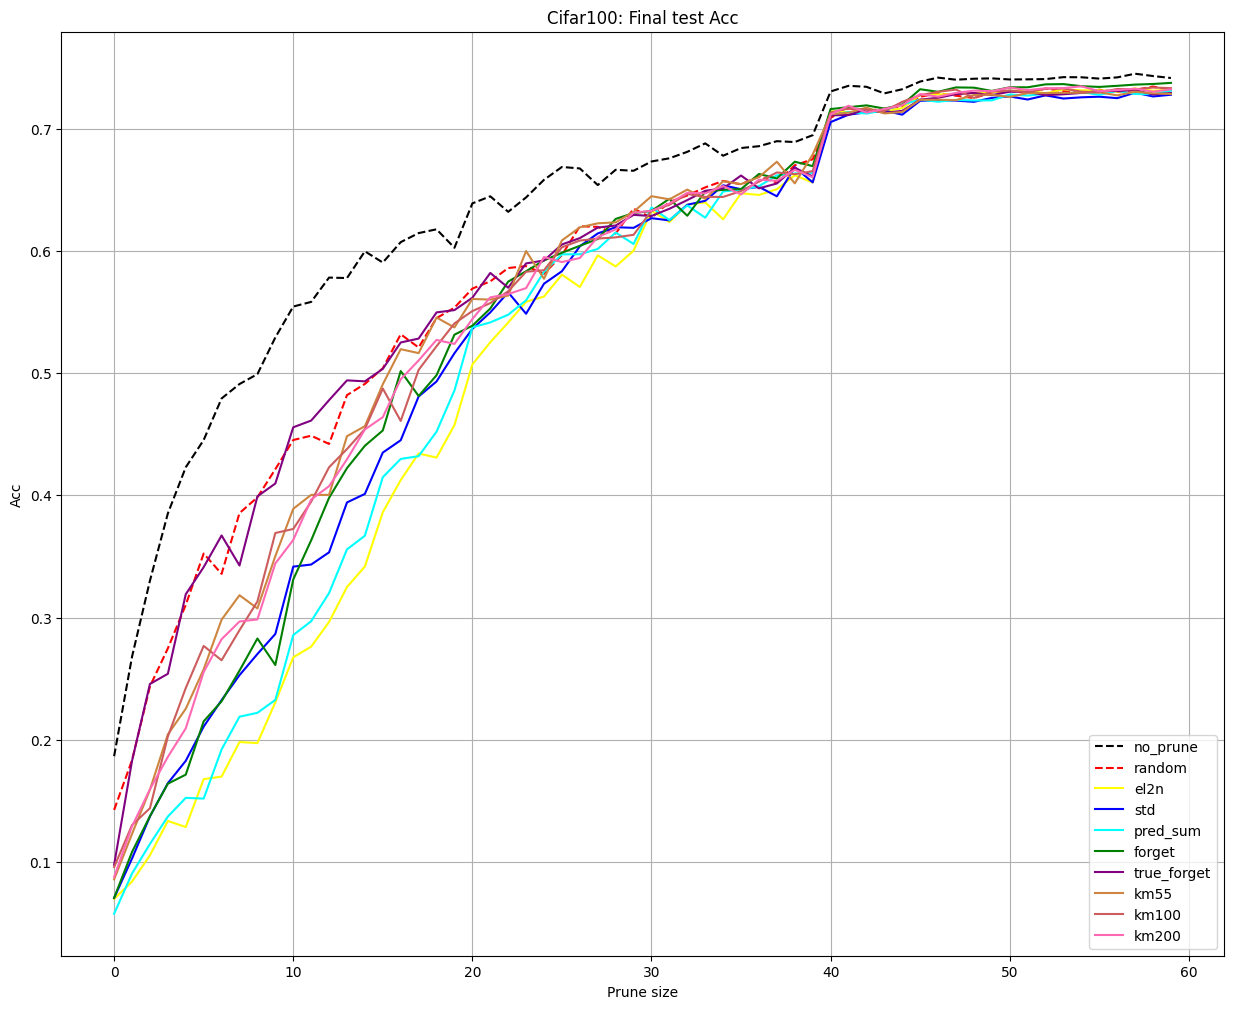

In [19]:
plt.figure(figsize=(15, 12))

colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'indianred', 'hotpink', 'darkorange',
          'deepskyblue')
#          no       rand    el2n     std     sum     flip      forget   km      km5            km10    km100
markers = ('dashed', 'solid')

for i, (prune_method, valid_acc) in enumerate(acc.items()):
    plt.plot(range(60), valid_acc[:60], label=prune_method,
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar100: Final test Acc')
plt.show()

In [20]:
exp_num = 1
already_trained_1 = True
print()
for name, idx in idx_sorted.items():
    model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_exp{exp_num}', dir_=NOTEBOOK_NAME,
                                 load=already_trained_1)
    for epochs, presents in [(20, .5), (10, .6), (10, .7), (10, .8), (10, .9), (20, 1.)]:
        print(f'====     train model with {presents}% according to {name} method    ======')
        if not already_trained_1:
            loader_train = get_loader(dataset_train, idx[-round(presents * NUM_TRAIN):], batch_size=BATCH_SIZE,
                                      shuffle=True)
            model_manager.train(loader_train, loader_test, loader_test, epochs)
        acc[name] = model_manager.data['valid']['acc']
        print()


Adjusting learning rate of group 0 to 1.0000e-03.
====     train model with 0.5% according to random method    ======

====     train model with 0.6% according to random method    ======

====     train model with 0.7% according to random method    ======

====     train model with 0.8% according to random method    ======

====     train model with 0.9% according to random method    ======

====     train model with 1.0% according to random method    ======

Adjusting learning rate of group 0 to 1.0000e-03.
====     train model with 0.5% according to el2n method    ======

====     train model with 0.6% according to el2n method    ======

====     train model with 0.7% according to el2n method    ======

====     train model with 0.8% according to el2n method    ======

====     train model with 0.9% according to el2n method    ======

====     train model with 1.0% according to el2n method    ======

Adjusting learning rate of group 0 to 1.0000e-03.
====     train model with 0.5% ac

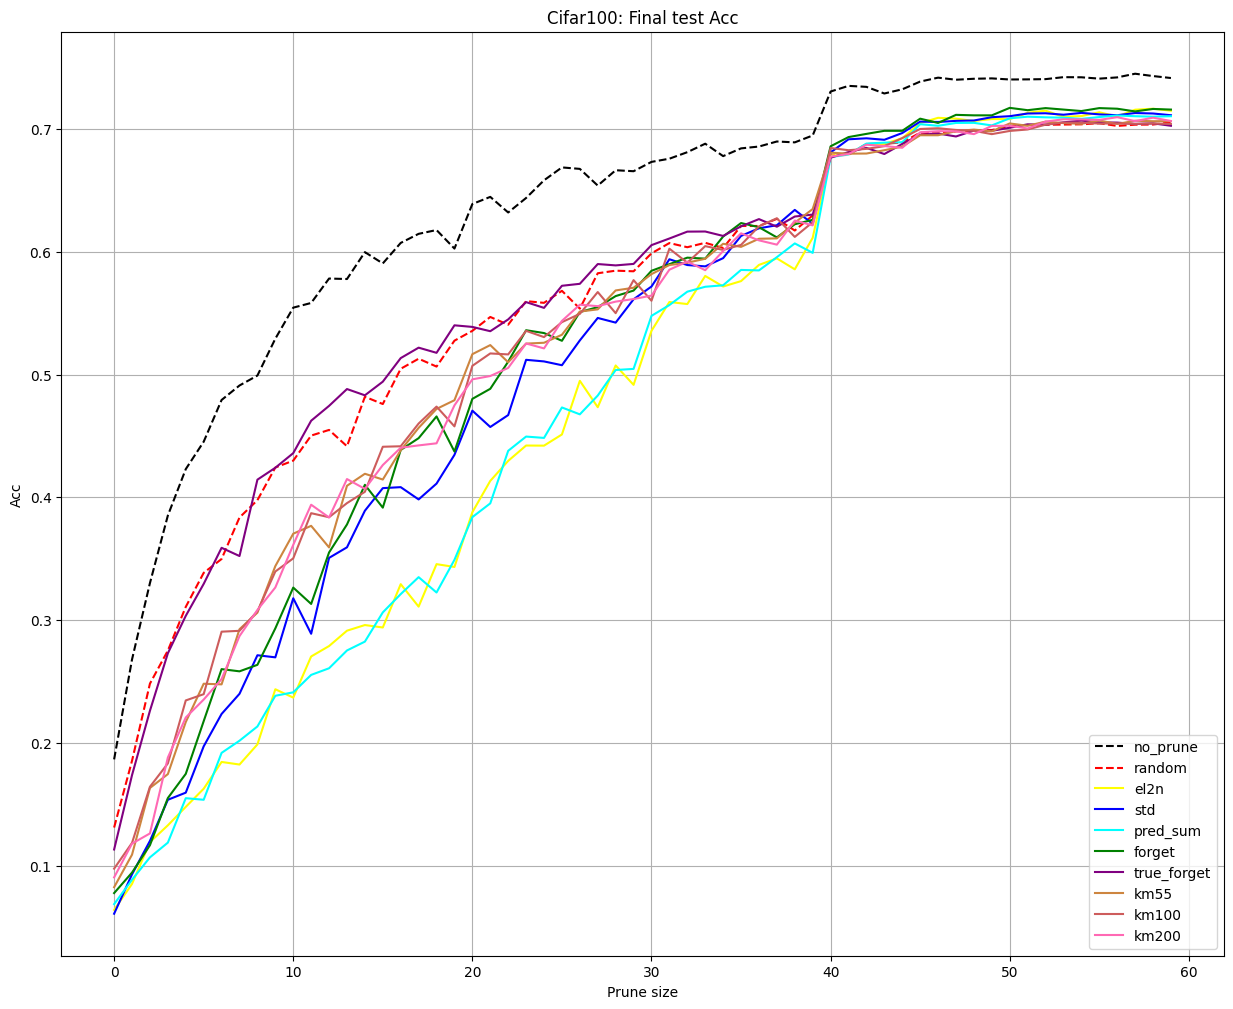

In [21]:
plt.figure(figsize=(15, 12))

colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'indianred', 'hotpink', 'darkorange',
          'deepskyblue')
#          no       rand    el2n     std     sum     flip      forget   km      km5            km10    km100
markers = ('dashed', 'solid')

for i, (prune_method, valid_acc) in enumerate(acc.items()):
    plt.plot(range(60), valid_acc[:60], label=prune_method,
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar100: Final test Acc')
plt.show()